In [1]:
from random import random, choices, randint
from collections import Counter
from scipy.stats import binom
from statistics import mean,stdev, variance
import matplotlib.pyplot as plt
from numpy import sqrt, power
from copy import deepcopy
import numpy as np

# Organism and Genome Classes

## Genome
these classes define a simple genome, which consists of a vector of zeros. Genome constructors can take a list of values as its inherated sites

## Organism
organisms have a genome, track their offspring counts, and can make mutated copies of themselves. They report their own fitness by evaluating themselves on the fitness function supplied.

In [2]:
#org and genome classes

class Genome:
    def __init__(self,sites,genomeLength):
        if sites is None:
            self.sites = self.initSites(genomeLength)
            self.length = genomeLength
        else:
            self.sites = sites
            self.length = len(sites)
          
        
    def initSites(self,genomeLength):
        # all zeroes; good for sawtooth or max-1
        return [0 for _ in range(genomeLength)]

    
    
class Organism:
    def __init__(self,genome,genomeLength,ancesterID = -1):
        if genome is None:
            self.genome = Genome(None,genomeLength)
        else:
            self.genome = genome
        self.offspringCount = 0
        self.fitness = None
        self.ancesterID = ancesterID
            
    
    def makeMutatedCopy(self,):
        global MU
        self.offspringCount += 1
        
        newOrganism = Organism(deepcopy(self.genome),self.genome.length)
        newOrganism.ancesterID = self.ancesterID
        for i in range(newOrganism.genome.length):
            if random() <= MU:
                sign = 1 if random() <= 0.5 else -1
                newOrganism.genome.sites[i] += sign
        return newOrganism
    
    
    def getFitness(self,evalFunc):
        if self.fitness is None:
            self.fitness = evalFunc(self)
        return self.fitness

# fitness functions
## sawtooth
the sawtooth function is an infinite hillclimb with fitness valleys between each step up the hill. The width and depth of the valley are configured by w and d respectively, while r determines the slope (rise) of the hillclimb. 

## other fitness functions
Other fitness functions implement various polynomial relationships to the sum of the genome's site values. 

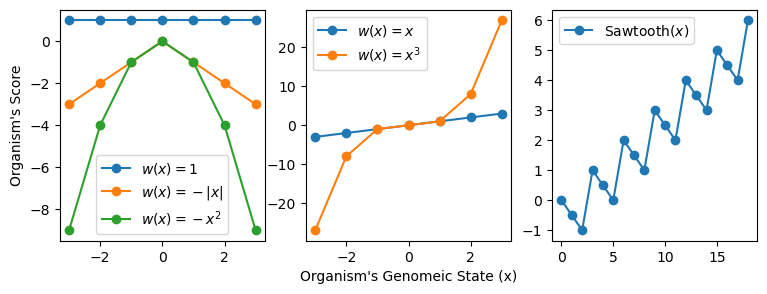

In [3]:
#fitness functions

def sawtooth(organism,plot=False):
    w = 2 #valley width
    d = 1 #valley depth
    r = 1 #fitness rise peak to peak
    
    if plot:
        anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
        plt.figure(figsize=(4,3))
        plt.plot([anon(v) for v in range(0,19)],marker="o",label="Sawtooth$(x)$")
        plt.ylabel("Organism's Score")
        plt.xlabel("Organism's Genomeic State (x)")
        plt.legend()
        plt.show()
        return
    
    x = sum(organism.genome.sites)
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w))


def constFitness(_):
    return 1

def linearFitness(organism):
    x = sum(organism.genome.sites)
    return x

def absPeak(organism):
    x = sum(organism.genome.sites)
    return -abs(x)

def cubicFitness(organism):
    x = sum(organism.genome.sites)
    return x**3


def quadraticPeak(organism):
    x = sum(organism.genome.sites)
    return -(x**2)

#plot fitness functions

start = -3
end = 3
fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].plot([v for v in range(start,end+1)],[1 for v in range(start,end+1)],marker="o",label="$w(x)=1$")
axs[0].plot([v for v in range(start,end+1)],[-abs(v) for v in range(start,end+1)],marker="o",label="$w(x)=-|x|$")
axs[0].plot([v for v in range(start,end+1)],[-(v**2) for v in range(start,end+1)],marker="o",label="$w(x)=-x^2$")
axs[1].plot([v for v in range(start,end+1)],[v for v in range(start,end+1)],marker="o",label="$w(x)=x$")
axs[1].plot([v for v in range(start,end+1)],[v**3 for v in range(start,end+1)],marker="o",label="$w(x)=x^3$")
axs[0].set_ylabel("Organism's Score")
axs[1].set_xlabel("Organism's Genomeic State (x)")
axs[0].legend()
axs[1].legend()
w = 2 #valley width
d = 1 #valley depth
r = 1 #fitness rise peak to peak
anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
axs[2].plot([anon(v) for v in range(0,19)],marker="o",label="Sawtooth$(x)$")
axs[2].legend()
plt.savefig('FitnessFunctions.pdf', bbox_inches='tight')
plt.show()

# selection algorithms
## tournament
choose a number of organisms at random, then keep the best. Choose with replacement to match the mathematics used in the paper. 
## roulette
choose proportional to 1.05**fitness, the exponent ensures we avoid diminishing returns on the sawtooth.

In [4]:
def tournament_select(population,size=2):
    global EVAL_FUNC
    return max(choices(population,k=size),key=lambda org: org.getFitness(EVAL_FUNC))

def roulette_select(population,batchSize,exp=1.05):
    global POP_SIZE, EVAL_FUNC
    MAX = max([org.getFitness(EVAL_FUNC) for org in population])
    F = [ power(exp,org.getFitness(EVAL_FUNC)-MAX) for org in population]
    S = sum(F)
    return choices(list(range(POP_SIZE)),k=batchSize,weights=[f/S for f in F])

# selection impact fundamentals
## Drift Reference
these are the equations that graph the distribution of offspring per parents/ancesters given the relevant inputs
## emd
earth-mover distance, computed as described in the publication.
## get wright-fisher selection impact
given a vector of offspring counts (one per parent), compute the selection impact as the EMD of the observed distribution and the theoreteical distribution.
## utilities
### get significance threshold
this function computes a 0.05 p-value threshold for the drift distribution. Any offspring larger than that value are expected to occurr less than 5% of the time
### dictionary reduce
a helper function for merging dictionaries in a manner useful for computing the selection impact

In [5]:
#selection strength components
DR = {}
def WFDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]


def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


def get_WF_SI(offCounts_1d):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(N_final+1)]
    return emd(WFDriftReference(N_init,N_final),Observed)


# Utilities

def getSigThreshold(DR,p=0.05):
    probVal = 1.0
    index_i = 0
    while probVal > p:
        probVal -= DR[index_i]
        index_i += 1
    return index_i


def dictionaryReduce(listOfDict,target={}):
    #NOTE: if the target and listOfDict both lack a key,
    #      the updated target will not contain an entry for that key:
    #      this function aims to include zeros for missing keys
    #      therefore, some entries may lack zeros if they are not 
    #      represented in the initial set of keys provided; this function is
    #      best used when listOfDict is the final set of dics to be reduced
    maxKey = max([max(d.keys()) for d in listOfDict]+[max(list(target.keys())+[-1])])
    for dic in listOfDict:
        for key in range(maxKey+1):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

# Proof of concept
here i demonstrate a basic implementation of the wright-fisher selection impact metric. The model below is configurable with different population sizes, genome lengths, mutation rates, and generations, and can be run on any single fitness function, using tournament or roulette selection, each with parameters for "selection strength". 

### note
the figures generated do not appear in the publication. They are merely a diagnostic tool to verify the validity of the model.

In [6]:
#parameters

POP_SIZE = 1000
GENOME_LENGTH = 1
MU = 1/20
GENERATIONS = 5000


EVAL_FUNC = sawtooth
# EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness
# EVAL_FUNC = onePeak


SELECTION_METHOD = "Tournament"
# SELECTION_METHOD = "Roulette"
TSIZE = 2
REXP = float(5)


In [7]:
# basic WF theory confirmation

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
dataLog = []
offCountAcc = {}

for generation in range(GENERATIONS):
    print(int(100*generation/GENERATIONS),"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    varFitness = stdev([org.getFitness(EVAL_FUNC) for org in population])
    
    #tournament
    if SELECTION_METHOD == "Tournament":
        newPopulation = [tournament_select(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    #roulette
    elif SELECTION_METHOD == "Roulette":
        newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
    else:
        print("ERROR: invalid selection method")
    
    offspringCounts = [org.offspringCount for org in population]
    offCountAcc = dictionaryReduce([Counter(offspringCounts)],target=offCountAcc)
    selectionStrength = get_WF_SI(offspringCounts)
    dataLog.append((aveFitness,selectionStrength,varFitness))
    population = newPopulation
print()
    
aveFitLog, selStrLog, varFitLog = list(zip(*dataLog))


99 % %


/tmp/ipykernel_19766/1505788352.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  axs[2].plot([s/v for s,v in zip(selStrLog,varFitLog)])


0.03342945009565158 0.014946628754566527


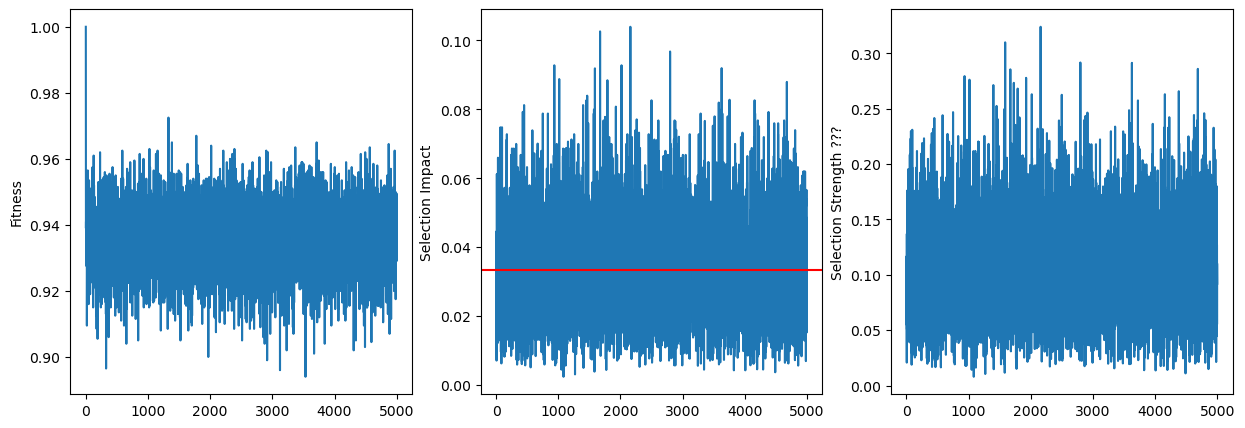

checkSum (1.0) 1.0
Larger than 5 offspring is signifigantly more than expected by drift.


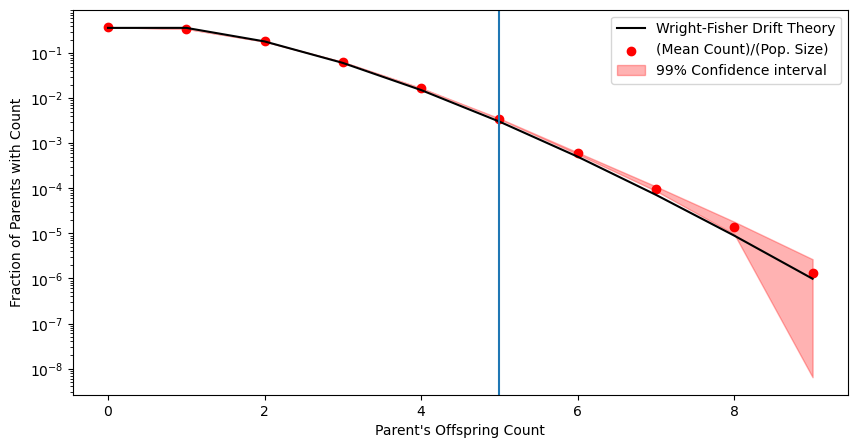

In [8]:
#plot WF results
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].set_ylabel("Fitness")
axs[0].plot(aveFitLog)
axs[1].set_ylabel("Selection Impact")
axs[1].plot(selStrLog)
axs[2].set_ylabel("Selection Strength ???")
axs[2].plot([s/v for s,v in zip(selStrLog,varFitLog)])
print(mean(selStrLog),stdev(selStrLog))
axs[1].axhline(mean(selStrLog),color="r")
plt.show()


print("checkSum (1.0)", sum([sum(V) for V in offCountAcc.values()]) / (GENERATIONS*POP_SIZE) )
meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

plt.figure(figsize=(10,5))
plt.plot(WFDriftReference(POP_SIZE,POP_SIZE)[:max(offCountAcc.keys())+1],
         label="Wright-Fisher Drift Theory",color="k")

sigthresh = getSigThreshold(WFDriftReference(POP_SIZE,POP_SIZE),p=0.01)
print("Larger than",sigthresh,
      "offspring is signifigantly more than expected by drift.")
plt.axvline(sigthresh)
plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
plt.show()

# selection impact & population size
this code computes the selection impact as a function of population size

the aim of this is to demonstrate that the selection impact can detect meaningful differences in the dynamics of evolution

we test a mix of stabilizing selection and directional selection, strong and weak graadients, and neutral drift. 

## paper reproduction
In the paper I examine a range of 25 values from 2 to 10**4 evenly spaced on a log scale. I run each population on each fitness function for 5000 generations using a mutation rate of 1/8 per site per genome. Genome length in the published figures is 1. Selection method in published figures is roulette selection. 

In [ ]:
# population size, effects on drift measure

popsizerange=[round(x) for x in np.logspace(0,4,25) if round(x) >=2]
popSSlog = []
GENERATIONS = 5000
MU = 1/8

for EVAL_FUNC in [constFitness, absPeak, linearFitness,quadraticPeak,cubicFitness]:
    for POP_SIZE in popsizerange:
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
#             newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]

            #roulette
            newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = get_WF_SI(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))



        print(POP_SIZE, mean(selStrLog),stdev(selStrLog))
        popSSlog.append((mean(selStrLog),stdev(selStrLog)))


        #plot WF results
        # fig, axs = plt.subplots(1,2,figsize=(10,5))
        # axs[0].plot(aveFitLog)
        # axs[0].set_xlabel("Generations")
        # axs[0].set_ylabel("Average Fitness")
        # axs[1].plot(selStrLog)
        # axs[1].set_xlabel("Generations")
        # axs[1].set_ylabel("Selection Impact Metric")
        # axs[1].axhline(mean(selStrLog),color="r")
        # plt.show()
    print()

2 0.5000000000000002 2.2200704205228663e-16
3 0.3110814814814816 0.23606968302615522
5 0.3175028480000015 0.12518718035643248
7 0.2627693713625159 0.11988451637616224
10 0.2297215726555228 0.09789749575694133
15 0.1812092170154392 0.09263110074995927
22 0.15721850074028948 0.07241301614625822
32 0.1346252735190909 0.05728718716932528
46 0.11031241931879257 0.0492565234177888
68 0.09087033155927943 0.04126178683667096
100 0.07608850068747229 0.03427575893998334
147 0.06317877284211681 0.027683811279430547
215 0.05151400688443939 0.023209713589554044
316 0.04255759193028471 0.01934983501306391
464 0.03563099442354336 0.015941238080484012
681 0.02958152246656851 0.013043662780156558
1000 0.024109628825425687 0.010887407248590065
1468 0.020037731958418754 0.008952184647447967
2154 0.016687177843199424 0.007245064626831607
3162 0.013834203539915846 0.006169080862028355
4642 0.011427149116802812 0.004967288681691819
6813 0.009298315781429716 0.00412286461366236


In [ ]:
# population size, effects on drift measure (plots)
ssmean, ssstd = list(zip(*popSSlog)) 

plt.figure(figsize=(8,5))
lineLabels = ["w(x) = 1","w(x) = $-|x|$","w(x) = $x$","w(x) = $-x^2$","w(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.plot(popsizerange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.fill_between(popsizerange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Population Size")
plt.ylabel("$S(f) =$ EMD$(f_D$,$f)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.title("Population size vs average EMD($f_D$,$f$)")
plt.axhline(0,color="k")
plt.savefig('popSizeSS.pdf', bbox_inches='tight')
plt.show()

# selection impact & mutation rate
this code computes the selection impact as a function of mutation rate

the aim of this is to demonstrate that the selection impact can detect meaningful differences in the dynamics of evolution

we test a mix of stabilizing selection and directional selection, strong and weak graadients, and neutral drift. 

## paper reproduction
In the paper I examine a range of 25 mutation rates (per site) from 10**-5 to 1 evenly spaced on a log scale. I run each population on each fitness function for 5000 generations using a population size of 500 organisms. Genome length in the published figures is 1. Selection method in published figures is roulette selection. 

In [ ]:
# MUR8, effects on drift measure

#murange = [1]+[1/(x*(GENOME_LENGTH*POP_SIZE)) for x in [1/2048,1/1024,1/512,1/256,1/128,1/64,1/32,1/16,1/8,1/4,1/2,1,2,4,8,16,32,64,128] if (x*(GENOME_LENGTH*POP_SIZE)) > 1]
murange = np.logspace(-5,0,25)
muSSlog = []
POP_SIZE = 500
GENERATIONS = 5000

for EVAL_FUNC in [constFitness, absPeak, linearFitness,quadraticPeak,cubicFitness]:
    for MU in murange:
        # print(MU)
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
    #         print(int(100*generation/GENERATIONS),"%",end="\r")
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
#             newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]

            #roulette
            newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = get_WF_SI(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))

        print(MU, mean(selStrLog),stdev(selStrLog))
        muSSlog.append((mean(selStrLog),stdev(selStrLog),mean([f-i for i,f in zip(aveFitLog[:-1],aveFitLog[1:])])))
        #plot WF results
    #     fig, axs = plt.subplots(1,2,figsize=(10,5))
    #     axs[0].plot(aveFitLog)
    #     axs[1].plot(selStrLog)
    #     axs[1].axhline(mean(selStrLog),color="r")
    #     plt.show()
    print()

In [ ]:
# MUR8, effects on drift measure (plots)
ssmean, ssstd, roamean = list(zip(*muSSlog)) 

plt.figure(figsize=(8,5))
lineLabels = ["w(x) = 1","w(x) = $-|x|$","w(x) = $x$","w(x) = $-x^2$","w(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.plot(murange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.fill_between(murange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s,_ in muSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s,_ in muSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Mutation Rate")
plt.ylabel("$S(f) =$ EMD$(f_D$,$f)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.title("mutation rate vs average selection strength")
plt.axhline(0,color="k")
plt.savefig('mutationRateSS.pdf', bbox_inches='tight')
plt.show()



